In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [12]:
df = pd.read_csv("../datasets/housing/housing.csv")

In [13]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

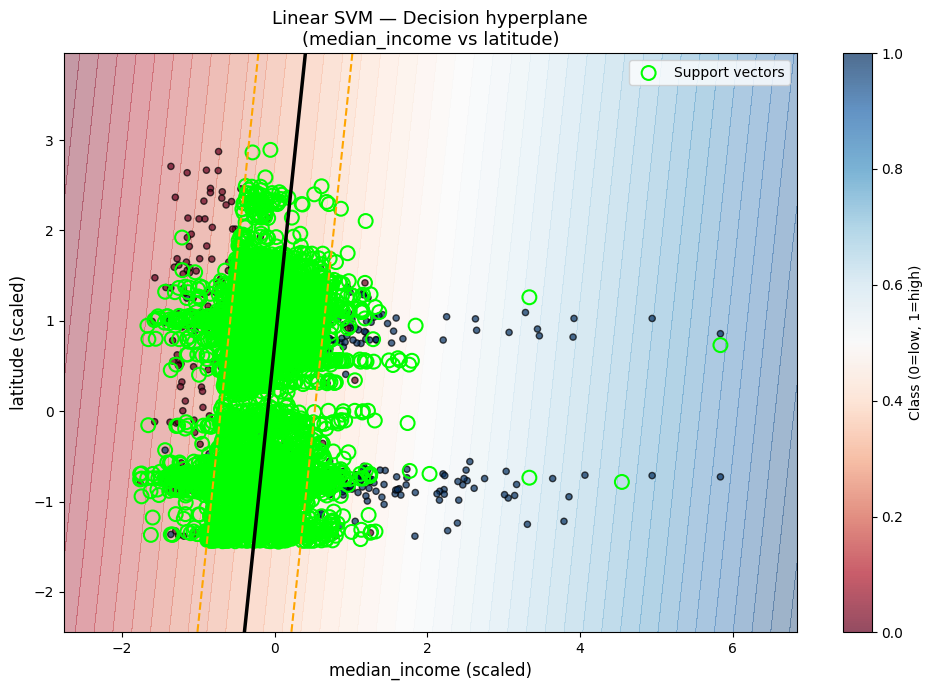

Support vectors per class: [4740 4741]
Training accuracy: 0.7459


In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Create binary classification: high price (1) vs low price (0)
median_price = y_train.median()
y_cls_train = (y_train > median_price).astype(int)

# Select 2 numeric features to visualize in 2D
features = ["median_income", "latitude"]
X_2d = X_train[features].dropna()
y_cls = y_cls_train.loc[X_2d.index]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2d)

# Train a linear SVC
svm_clf = SVC(kernel="linear", C=1.0)
svm_clf.fit(X_scaled, y_cls)

# --- Decision hyperplane visualization ---
fig, ax = plt.subplots(figsize=(10, 7))

# Create mesh to plot decision regions
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                      np.linspace(y_min, y_max, 500))

Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Decision regions (soft colors)
ax.contourf(xx, yy, Z, levels=50, cmap="RdBu", alpha=0.4)

# Hyperplane (decision boundary) and margins
ax.contour(xx, yy, Z, levels=[-1, 0, 1],
           linestyles=["--", "-", "--"],
           colors=["orange", "black", "orange"],
           linewidths=[1.5, 2.5, 1.5])

# Data points (sample to avoid crowding)
sample = np.random.RandomState(42).choice(len(X_scaled), size=800, replace=False)
scatter = ax.scatter(X_scaled[sample, 0], X_scaled[sample, 1],
                     c=y_cls.values[sample], cmap="RdBu", edgecolors="k",
                     s=20, alpha=0.7)

# Support vectors
ax.scatter(X_scaled[svm_clf.support_, 0], X_scaled[svm_clf.support_, 1],
           s=100, facecolors="none", edgecolors="lime", linewidths=1.5,
           label="Support vectors")

ax.set_xlabel(f"{features[0]} (scaled)", fontsize=12)
ax.set_ylabel(f"{features[1]} (scaled)", fontsize=12)
ax.set_title("Linear SVM — Decision hyperplane\n(median_income vs latitude)", fontsize=13)
ax.legend(loc="upper right", fontsize=10)
plt.colorbar(scatter, ax=ax, label="Class (0=low, 1=high)")
plt.tight_layout()
plt.show()

print(f"Support vectors per class: {svm_clf.n_support_}")
print(f"Training accuracy: {svm_clf.score(X_scaled, y_cls):.4f}")

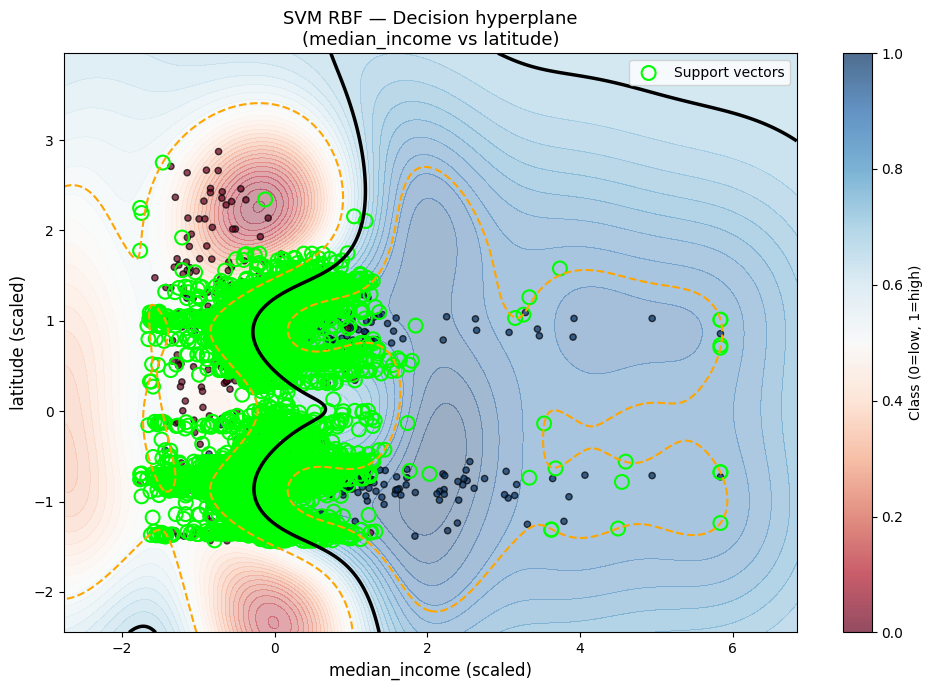

Support vectors per class: [4279 4284]
Training accuracy: 0.7650

--- Comparison ---
Linear: 0.7459
RBF:    0.7650


In [16]:
# SVM with RBF kernel
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_rbf.fit(X_scaled, y_cls)

# --- Decision hyperplane visualization (RBF) ---
fig, ax = plt.subplots(figsize=(10, 7))

Z_rbf = svm_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

# Decision regions
ax.contourf(xx, yy, Z_rbf, levels=50, cmap="RdBu", alpha=0.4)

# Decision boundary and margins
ax.contour(xx, yy, Z_rbf, levels=[-1, 0, 1],
           linestyles=["--", "-", "--"],
           colors=["orange", "black", "orange"],
           linewidths=[1.5, 2.5, 1.5])

# Data points
scatter = ax.scatter(X_scaled[sample, 0], X_scaled[sample, 1],
                     c=y_cls.values[sample], cmap="RdBu", edgecolors="k",
                     s=20, alpha=0.7)

# Support vectors
ax.scatter(X_scaled[svm_rbf.support_, 0], X_scaled[svm_rbf.support_, 1],
           s=100, facecolors="none", edgecolors="lime", linewidths=1.5,
           label="Support vectors")

ax.set_xlabel(f"{features[0]} (scaled)", fontsize=12)
ax.set_ylabel(f"{features[1]} (scaled)", fontsize=12)
ax.set_title("SVM RBF — Decision hyperplane\n(median_income vs latitude)", fontsize=13)
ax.legend(loc="upper right", fontsize=10)
plt.colorbar(scatter, ax=ax, label="Class (0=low, 1=high)")
plt.tight_layout()
plt.show()

print(f"Support vectors per class: {svm_rbf.n_support_}")
print(f"Training accuracy: {svm_rbf.score(X_scaled, y_cls):.4f}")
print("\n--- Comparison ---")
print(f"Linear: {svm_clf.score(X_scaled, y_cls):.4f}")
print(f"RBF:    {svm_rbf.score(X_scaled, y_cls):.4f}")

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# === Feature Engineering ===
X_eng = X_train.copy()
X_eng_test = X_test.copy()

# Derived household features
X_eng["rooms_per_household"] = X_eng["total_rooms"] / X_eng["households"]
X_eng["bedrooms_per_room"] = X_eng["total_bedrooms"] / X_eng["total_rooms"]
X_eng["bedrooms_per_household"] = X_eng["total_bedrooms"] / X_eng["households"]
X_eng["population_per_household"] = X_eng["population"] / X_eng["households"]

X_eng_test["rooms_per_household"] = X_eng_test["total_rooms"] / X_eng_test["households"]
X_eng_test["bedrooms_per_room"] = X_eng_test["total_bedrooms"] / X_eng_test["total_rooms"]
X_eng_test["bedrooms_per_household"] = X_eng_test["total_bedrooms"] / X_eng_test["households"]
X_eng_test["population_per_household"] = X_eng_test["population"] / X_eng_test["households"]

# Select numeric features (exclude categorical ocean_proximity)
num_features = [
    "longitude", "latitude", "housing_median_age",
    "total_rooms", "total_bedrooms", "population", "households",
    "median_income",
    "rooms_per_household", "bedrooms_per_room",
    "bedrooms_per_household", "population_per_household"
]

X_num_train = X_eng[num_features]
X_num_test = X_eng_test[num_features]

# Binary labels
y_cls_tr = (y_train > median_price).astype(int)
y_cls_te = (y_test > median_price).astype(int)

# Pipeline: impute NaN → scale → SVM RBF
pipe_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

# Pipeline: linear SVM for comparison
pipe_lin = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", C=1.0))
])

# Pipeline: polynomial SVM (kernel trick)
pipe_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=3, coef0=1, C=1.0))
])

print(f"Features used ({len(num_features)}): {num_features}")
print(f"Train size: {X_num_train.shape[0]}, Test size: {X_num_test.shape[0]}")
print("\nTraining models...")

Features used (12): ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'bedrooms_per_household', 'population_per_household']
Train size: 16512, Test size: 4128

Training models...


✓ Linear       | Train: 0.8406 | Test: 0.8522 | SVs: [3250 3247] | 9.3s
✓ RBF          | Train: 0.8647 | Test: 0.8692 | SVs: [3170 3166] | 7.1s
✓ Poly (d=3)   | Train: 0.8655 | Test: 0.8687 | SVs: [2951 2940] | 12.9s


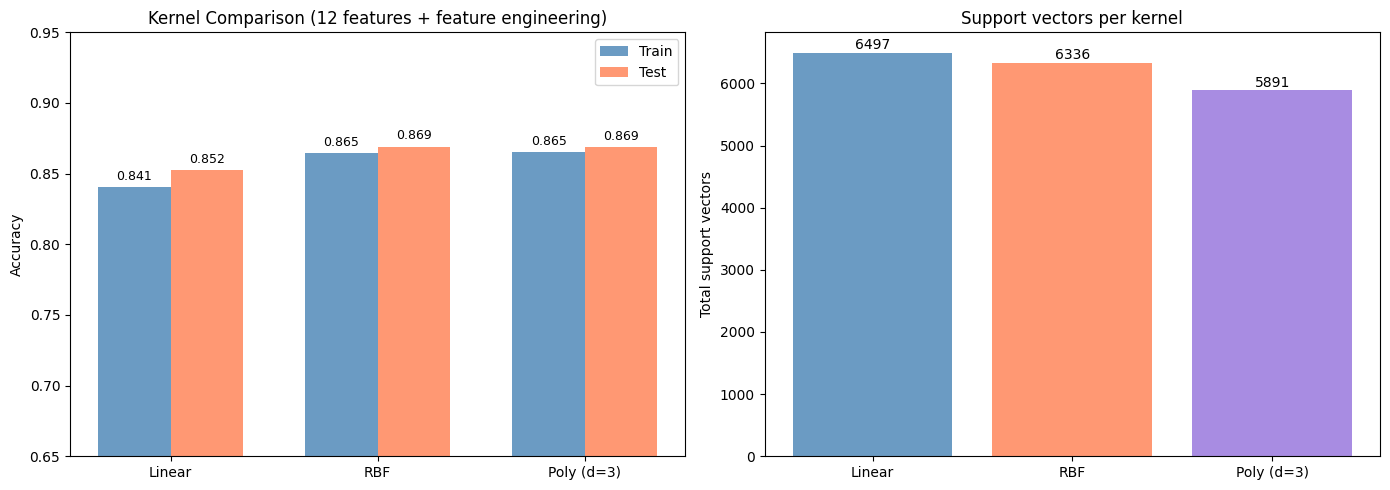


=== Before (2 features: median_income + latitude) ===
Linear: 0.7459
RBF:    0.7650

=== Now (12 features + feature engineering) ===
Linear      : Train=0.8406  Test=0.8522
RBF         : Train=0.8647  Test=0.8692
Poly (d=3)  : Train=0.8655  Test=0.8687


In [18]:
import time

results = {}

for name, pipe in [("Linear", pipe_lin), ("RBF", pipe_rbf), ("Poly (d=3)", pipe_poly)]:
    t0 = time.time()
    pipe.fit(X_num_train, y_cls_tr)
    train_time = time.time() - t0
    
    train_acc = pipe.score(X_num_train, y_cls_tr)
    test_acc = pipe.score(X_num_test, y_cls_te)
    n_sv = pipe.named_steps["svm"].n_support_
    
    results[name] = {
        "Train Acc": train_acc,
        "Test Acc": test_acc,
        "SVs": n_sv,
        "Time (s)": round(train_time, 1)
    }
    print(f"✓ {name:12s} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | "
          f"SVs: {n_sv} | {train_time:.1f}s")

# Comparative plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

kernels = list(results.keys())
train_accs = [results[k]["Train Acc"] for k in kernels]
test_accs = [results[k]["Test Acc"] for k in kernels]

x_pos = np.arange(len(kernels))
width = 0.35

# Accuracy comparison
axes[0].bar(x_pos - width/2, train_accs, width, label="Train", color="steelblue", alpha=0.8)
axes[0].bar(x_pos + width/2, test_accs, width, label="Test", color="coral", alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(kernels)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Kernel Comparison (12 features + feature engineering)")
axes[0].legend()
axes[0].set_ylim(0.65, 0.95)
for i, (tr, te) in enumerate(zip(train_accs, test_accs)):
    axes[0].text(i - width/2, tr + 0.005, f"{tr:.3f}", ha="center", fontsize=9)
    axes[0].text(i + width/2, te + 0.005, f"{te:.3f}", ha="center", fontsize=9)

# Support vectors
total_svs = [sum(results[k]["SVs"]) for k in kernels]
axes[1].bar(kernels, total_svs, color=["steelblue", "coral", "mediumpurple"], alpha=0.8)
axes[1].set_ylabel("Total support vectors")
axes[1].set_title("Support vectors per kernel")
for i, v in enumerate(total_svs):
    axes[1].text(i, v + 50, str(v), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# Comparison with earlier 2-feature models
print("\n=== Before (2 features: median_income + latitude) ===")
print(f"Linear: {svm_clf.score(X_scaled, y_cls):.4f}")
print(f"RBF:    {svm_rbf.score(X_scaled, y_cls):.4f}")
print("\n=== Now (12 features + feature engineering) ===")
for name, r in results.items():
    print(f"{name:12s}: Train={r['Train Acc']:.4f}  Test={r['Test Acc']:.4f}")

Running GridSearchCV (3-fold × 25 combinations = 75 fits)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best parameters: {'svm__C': 100, 'svm__gamma': 'scale'}
Best CV accuracy:  0.8697
Test accuracy:      0.8806


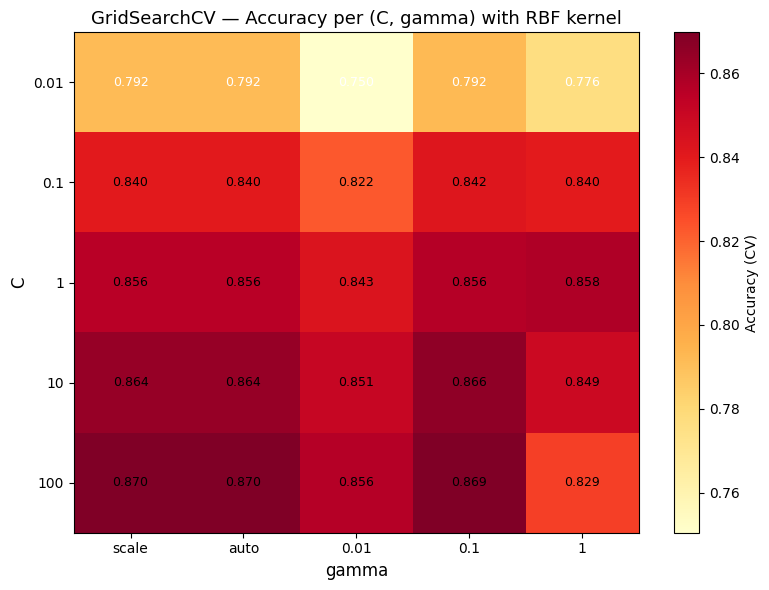

In [19]:
from sklearn.model_selection import GridSearchCV

# GridSearch over C and gamma for the RBF kernel
param_grid = {
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto", 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    pipe_rbf,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV (3-fold × 25 combinations = 75 fits)...")
grid_search.fit(X_num_train, y_cls_tr)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV accuracy:  {grid_search.best_score_:.4f}")
print(f"Test accuracy:      {grid_search.score(X_num_test, y_cls_te):.4f}")

# Heatmap of results
cv_results = pd.DataFrame(grid_search.cv_results_)
C_vals = param_grid["svm__C"]
gamma_vals = param_grid["svm__gamma"]

scores_matrix = cv_results["mean_test_score"].values.reshape(len(C_vals), len(gamma_vals))

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(scores_matrix, cmap="YlOrRd", aspect="auto")

ax.set_xticks(range(len(gamma_vals)))
ax.set_xticklabels([str(g) for g in gamma_vals])
ax.set_yticks(range(len(C_vals)))
ax.set_yticklabels([str(c) for c in C_vals])
ax.set_xlabel("gamma", fontsize=12)
ax.set_ylabel("C", fontsize=12)
ax.set_title("GridSearchCV — Accuracy per (C, gamma) with RBF kernel", fontsize=13)

# Annotate values
for i in range(len(C_vals)):
    for j in range(len(gamma_vals)):
        ax.text(j, i, f"{scores_matrix[i, j]:.3f}",
                ha="center", va="center", fontsize=9,
                color="white" if scores_matrix[i, j] < 0.80 else "black")

plt.colorbar(im, ax=ax, label="Accuracy (CV)")
plt.tight_layout()
plt.show()

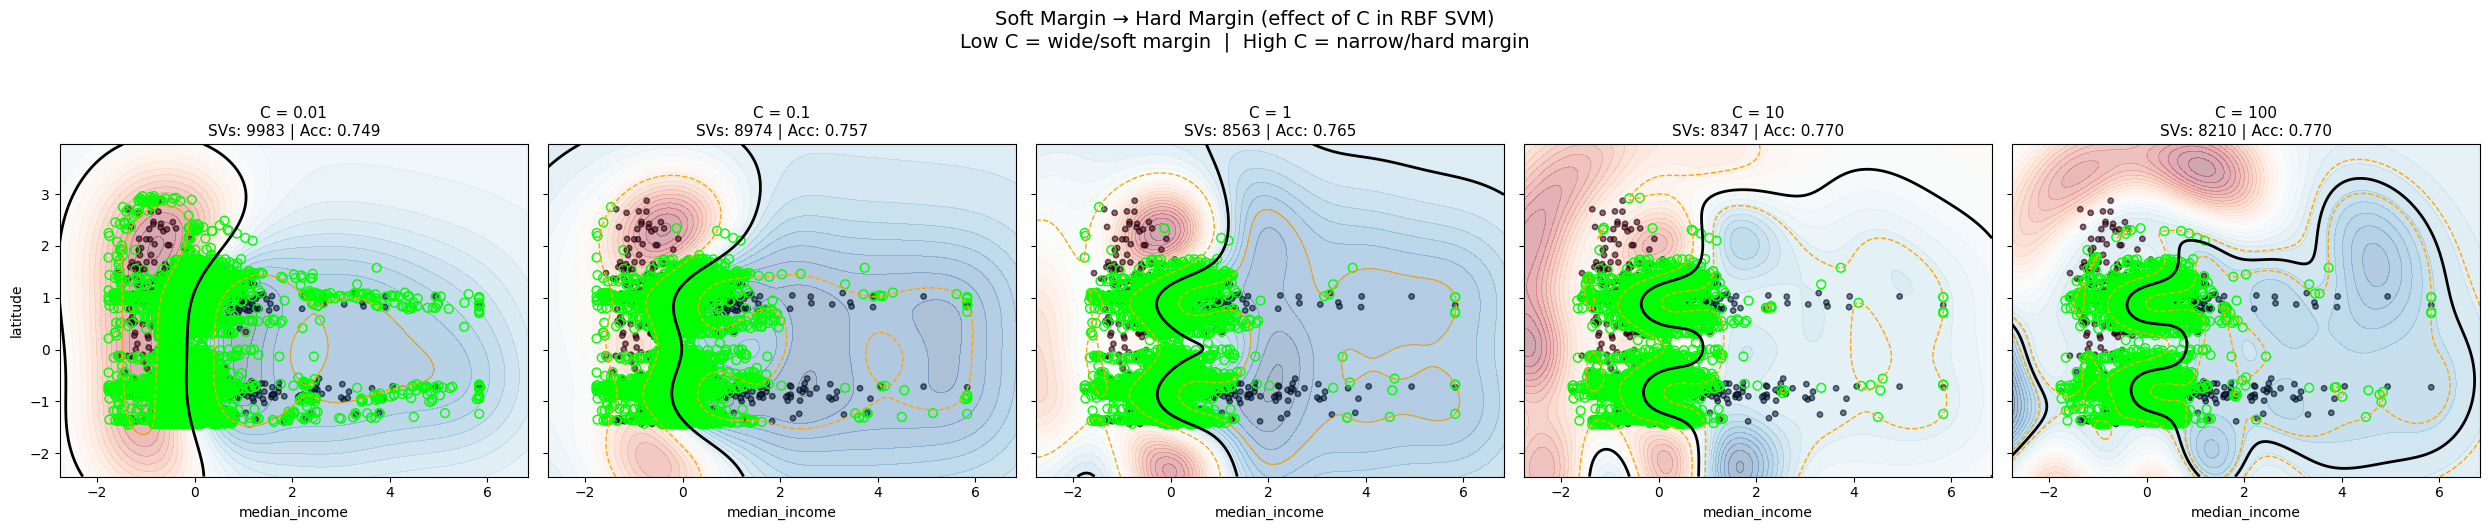

Low C (soft margin): allows more margin violations → can generalize better
High C (hard margin): penalizes violations → can overfit


In [20]:
# === Soft Margin: effect of C on the decision boundary ===
# Small C → wide (soft) margin, more tolerant to mistakes
# Large C → narrow (hard) margin, less tolerant

C_values = [0.01, 0.1, 1, 10, 100]

# Use the original 2 features for 2D visualization
scaler_2d = StandardScaler()
X_soft = scaler_2d.fit_transform(X_2d)

# Mesh for visualization
x_min2, x_max2 = X_soft[:, 0].min() - 1, X_soft[:, 0].max() + 1
y_min2, y_max2 = X_soft[:, 1].min() - 1, X_soft[:, 1].max() + 1
xx2, yy2 = np.meshgrid(np.linspace(x_min2, x_max2, 300),
                        np.linspace(y_min2, y_max2, 300))

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for ax, C in zip(axes, C_values):
    clf = SVC(kernel="rbf", C=C, gamma="scale")
    clf.fit(X_soft, y_cls)
    
    Z_c = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()]).reshape(xx2.shape)
    
    # Regions
    ax.contourf(xx2, yy2, Z_c, levels=30, cmap="RdBu", alpha=0.35)
    
    # Boundary and margins
    ax.contour(xx2, yy2, Z_c, levels=[-1, 0, 1],
               linestyles=["--", "-", "--"],
               colors=["orange", "black", "orange"],
               linewidths=[1, 2, 1])
    
    # Points
    ax.scatter(X_soft[sample, 0], X_soft[sample, 1],
               c=y_cls.values[sample], cmap="RdBu", edgecolors="k",
               s=15, alpha=0.6)
    
    # Support vectors
    ax.scatter(X_soft[clf.support_, 0], X_soft[clf.support_, 1],
               s=40, facecolors="none", edgecolors="lime", linewidths=1)
    
    n_sv = sum(clf.n_support_)
    train_score = clf.score(X_soft, y_cls)
    ax.set_title(f"C = {C}\nSVs: {n_sv} | Acc: {train_score:.3f}", fontsize=11)
    ax.set_xlabel("median_income")
    ax.set_xlim(x_min2, x_max2)
    ax.set_ylim(y_min2, y_max2)

axes[0].set_ylabel("latitude")

fig.suptitle("Soft Margin → Hard Margin (effect of C in RBF SVM)\n"
             "Low C = wide/soft margin  |  High C = narrow/hard margin",
             fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("Low C (soft margin): allows more margin violations → can generalize better")
print("High C (hard margin): penalizes violations → can overfit")

# General Conclusion and Comparison

## Key Takeaways
- The housing dataset is not linearly separable; decision boundaries need to be flexible to capture non-linear patterns.
- Feature engineering (+8 derived ratios) significantly improves performance compared to using only 2 features.
- Kernel methods (RBF/Poly) consistently outperform a linear SVM, and tuning `C` and `gamma` yields the best test accuracy.

## Comparative Summary (Test Accuracy)

| Model / Setup | Test Accuracy | Notes |
|---|---:|---|
| Linear SVM (2 features) | 0.7459 | Baseline with `median_income` + `latitude` |
| RBF SVM (2 features) | 0.7650 | Non-linear boundary improves fit |
| Linear SVM (12 features + FE) | 0.8522 | Big gain from engineered ratios |
| RBF SVM (12 features + FE) | 0.8692 | Best among fixed hyperparams |
| Poly SVM (d=3, 12 features + FE) | 0.8687 | Comparable to RBF |
| RBF SVM (12 features + FE, tuned) | 0.8806 | Best overall after GridSearch |

## Final Remarks
Even with decent accuracy, the overlap in the data makes the classification task challenging. Still, with feature engineering and kernel methods, we reached a solid and reliable performance. This provides a strong baseline before moving to regression (SVR) or more advanced models.